# Description ✒️
This challenge serves as final project for the "How to win a data science competition" Coursera course.

In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 

We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.

# Evaluation 📐
Submissions are evaluated by root mean squared error (RMSE). True target values are clipped into [0,20] range.

Submission File 📤

For each id in the test set, you must predict a total number of sales. The file should contain a header and have the following format:


|ID|item_cnt_month|
|:----|:-------|
|0|0.5|
|1|0.5|
|2|0.5|
|3|0.5|


In [2]:
  !pip install googletrans==4.0.0rc1 &> /dev/null 

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from wordcloud import WordCloud,  STOPWORDS
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


In [5]:
plt.rcParams["figure.figsize"] = (12, 8)

# Data Description
You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.
# **📚File descriptions**
* **sales_train.csv** - the training set. Daily historical data from January 2013 to October 2015.
* **test.csv** - the test set. You need to forecast the sales for these shops and products for November 2015.
* **sample_submission.csv** - a sample submission file in the correct format.
* **items.csv** - supplemental information about the items/products.
* **item_categories.csv**  - supplemental information about the items categories.
* **shops.csv**- supplemental information about the shops.

# **📁Data fields**
* **ID** - an Id that represents a (Shop, Item) tuple within the test set
* **shop_id** - unique identifier of a shop
* **item_id** - unique identifier of a product
* **item_category_id** - unique identifier of item category
* **item_cnt_day** - number of products sold. You are predicting a monthly amount of this measure
* **item_price** - current price of an item
* **date** - date in format dd/mm/yyyy
* **date_block_num** - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* **item_name** - name of item
* **shop_name** - name of shop
* **item_category_name** - name of item category


In [6]:
shops_df = pd.read_csv("../input/competitive-data-science-predict-future-sales/shops.csv")
shops_df.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [7]:
from googletrans import Translator
translator = Translator()

item_df = pd.read_csv(
    "../input/competitive-data-science-predict-future-sales/items.csv",)\
            .merge( pd.read_csv("../input/competitive-data-science-predict-future-sales/item_categories.csv")\
                           .assign(category_name_eng=lambda x: x.item_category_name.apply(lambda text: translator.translate(text, src='ru',dest='en').text))
                                    ,on='item_category_id'
                                       ,how='inner'
                                           ,validate='m:1'
                      )
item_df.head()

,item_name,item_id,item_category_id,item_category_name,category_name_eng
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,Cinema - DVD
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,Cinema - DVD
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,Cinema - DVD
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD,Cinema - DVD
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD,Cinema - DVD


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


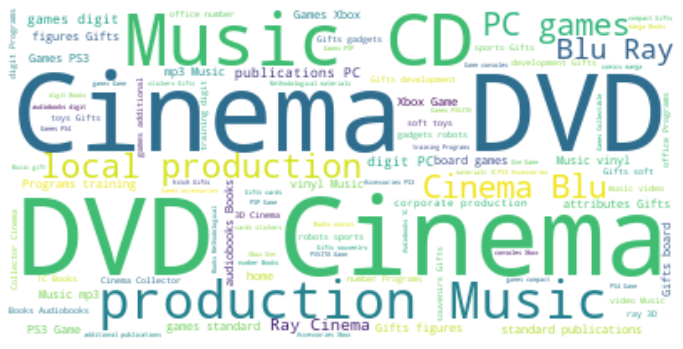

In [8]:
plt.imshow(
     WordCloud(stopwords = STOPWORDS, background_color="white").generate(" ".join(item_df.category_name_eng.str.replace("\W+"," ").tolist()))
     , interpolation='bilinear'
 )
plt.axis("off")
plt.show()

In [9]:
item_df.category_name_eng.unique()

array(['Cinema - DVD', 'Programs - for home and office (number)',
       'Music - CD of local production', 'Games - PS3',
       'PC games - standard publications', 'Games - Xbox 360',
       'Cinema - Blu -Ray', 'Cinema - Collector', 'Music - mp3',
       'Books are audiobooks', 'Programs - training (digit)',
       'Books are a number', 'Books - Methodological materials 1C',
       'Books - audiobooks (digit)', 'Books - Audiobooks 1C',
       'Programs - training', 'Programs - 1C: Enterprise 8',
       'PC games - digit', 'Programs - for home and office',
       'Music - vinyl', 'Music - CD of corporate production',
       'Cinema - Blu -ray 3D', 'Gifts - development',
       'Music - music video', 'Music - gift publications',
       'Programs - Mac (digit)', 'Games - PSP',
       'PC games - additional publications', 'Games - PS4',
       'Games - Xbox One', 'PC Games - Collectible Publications',
       'Gifts - souvenirs (in a hitch)', 'Games - PSVITA',
       'Payment cards (cinem

In [10]:
split_item_name = item_df.category_name_eng.str.split('-')
item_df["product_type"] = split_item_name.apply(lambda x: x[0].strip())
item_df["product_sub_type"] = split_item_name.apply(lambda x: x[1] if len(x)>1 else None)
item_df.loc[lambda x: x.category_name_eng.str.upper().str.contains( "PS\d|PSVITA|PSN|PSP|XBOX|PC GAMES|GAME CONSOLE|MAC GAMES" ),"product_type"] = 'Video Games'
item_df.loc[lambda x: x.category_name_eng.str.upper().str.contains( "BOOK" ),"product_type"] = 'Books'
item_df.loc[lambda x: x.category_name_eng.str.upper().str.contains( "GIFTS - CARDS|PAYMENT\s*CARDS" ),"product_type"] = "Gifts cards"

In [11]:
sales_train_df = pd.read_csv("../input/competitive-data-science-predict-future-sales/sales_train.csv",parse_dates=['date'])\
                    .merge(item_df,on='item_id')
sales_test_df = pd.read_csv("../input/competitive-data-science-predict-future-sales/test.csv")

In [12]:
item_category_monthly_sales = sales_train_df.set_index('date').groupby(["product_type"]).resample('M').item_cnt_day.sum().rename('item_cnt_monthly')
item_category_monthly_sales = pd.concat([item_category_monthly_sales, (item_category_monthly_sales.transform(lambda x: (x - x.shift(1)))).rename('delta')],axis=1).reset_index()

In [13]:
item_category_monthly_sales['n_day'] = item_category_monthly_sales.groupby(["product_type"]).date.transform(lambda x: (x - x.min())).dt.days

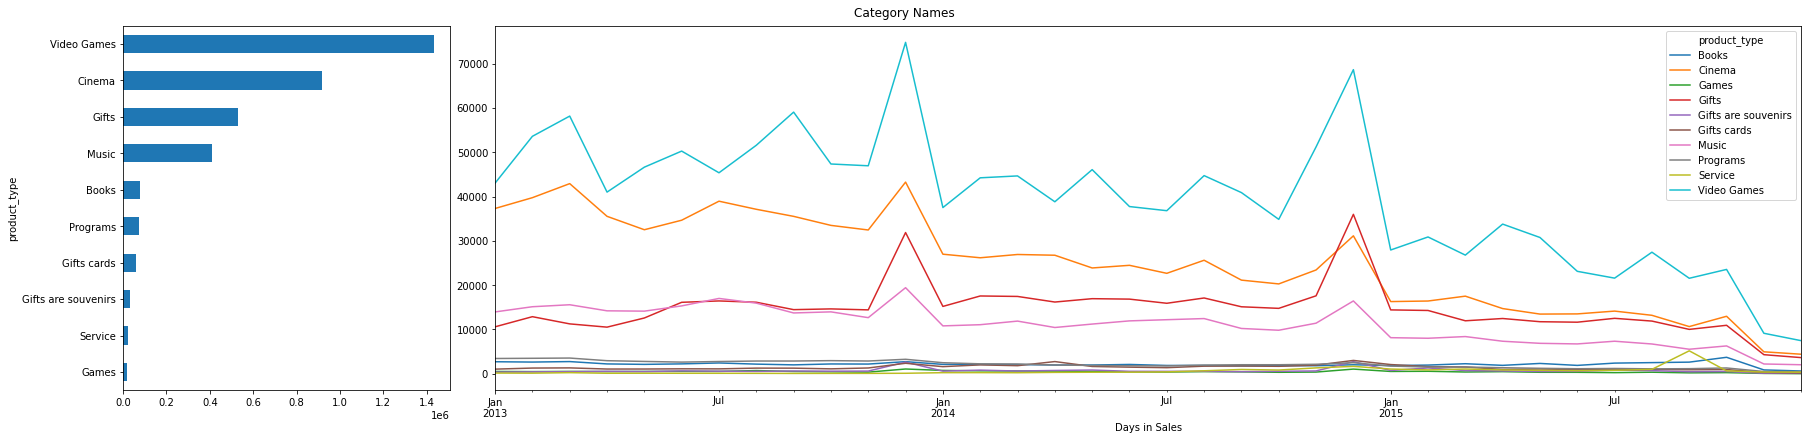

In [14]:
top_10_cat_df = item_category_monthly_sales.groupby('product_type').item_cnt_monthly.sum().sort_values(ascending=False)[:10]

fig = plt.figure(figsize=(25,6),constrained_layout=True)
spec = fig.add_gridspec(1, 5)
ax = fig.add_subplot(spec[0,0])
top_10_cat_df.sort_values().plot.barh(ax=ax)
ax2 = fig.add_subplot(spec[0,1:])
item_category_monthly_sales.loc[
    item_category_monthly_sales.product_type.isin(top_10_cat_df.index)
].pivot_table(index='date',columns='product_type',values='delta',aggfunc='sum').cumsum()\
.plot(ax=ax2)
plt.xlabel('Days in Sales')
plt.suptitle("Category Names")
plt.show()

In [15]:
item_monthly_sales_df = sales_train_df.set_index('date').groupby(["item_id","product_type"]).resample('M').item_cnt_day.sum().rename('item_cnt_monthly').reset_index()

In [16]:
item_monthly_sales_df['n_days'] = item_monthly_sales_df.groupby("item_id").date.transform(lambda x: x -x.min()).dt.days

In [17]:
corr_n_days_item_cnt = item_monthly_sales_df.groupby("product_type")[['item_cnt_monthly','n_days']].corr().loc[(slice(None),('n_days')),"item_cnt_monthly"].fillna(0).sort_values()

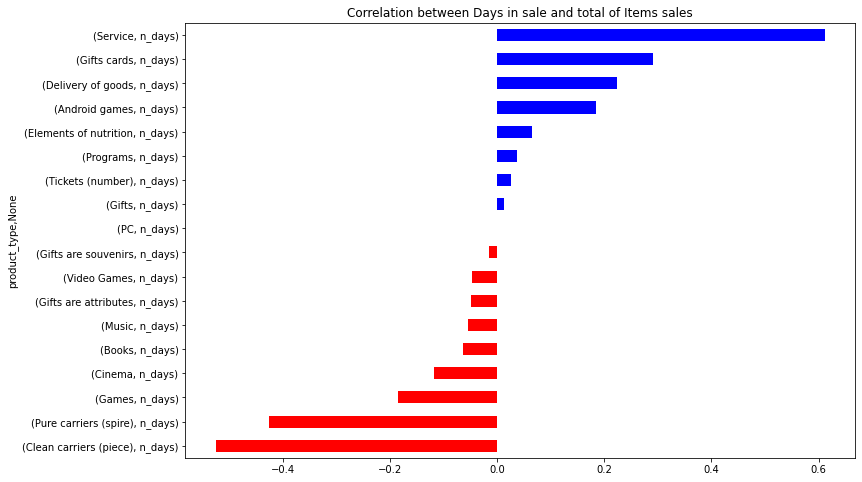

In [18]:
corr_n_days_item_cnt.plot.barh(title="Correlation between Days in sale and total of Items sales", color= list(map(lambda x: "r" if x <0 else 'b',corr_n_days_item_cnt)))
plt.show()

In [19]:
top_corr_items = corr_n_days_item_cnt.index.get_level_values('product_type')[-5:-1]

<AxesSubplot:xlabel='date'>

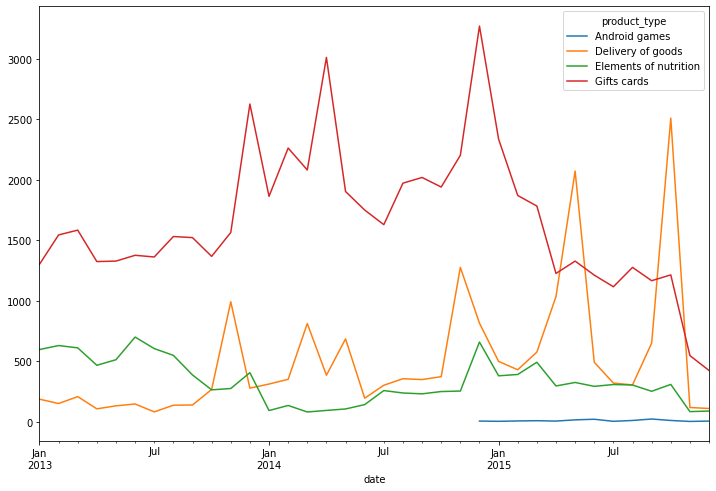

In [20]:
item_category_monthly_sales.loc[
    item_category_monthly_sales.product_type.isin(top_corr_items )
].pivot_table(index='date',columns='product_type',values='item_cnt_monthly',aggfunc='sum')\
.plot()

In [21]:
categorical_feature = ['product_type',"item_id"]

In [1]:
df =pd.get_dummies(item_monthly_sales_df,columns=categorical_feature)

NameError: name 'pd' is not defined